# We want to create an algorithm that will select the best strategy at any given datapoint based on the profitablility over the last 1 hour.
## To do this we'll need to create many dataframes and compare them.
##
Do all of our imports up top

In [15]:
import numpy as np
import os
import pickle
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pandas.io.data as web
%matplotlib inline

In [16]:
def get_dataframe():
    mydata = None
    try:
        mydata = pickle.load(open('modelling/stats_pickle5', 'rb'))
    except:
        mydata = pickle.load(open('../resources/stats_pickle5', 'rb'))
    df = pd.DataFrame(mydata, columns=["Time", "Value"])
    df = df.set_index('Time')
    return df

In [17]:
class Name():
    def __init__(self, means, sd):
        self.mean1 = str(means[0])+"hr"
        self.mean1_val = means[0]
        self.mean2 = str(means[1])+"hr"
        self.mean2_val = means[1]
        self.name = "{}-{}-{}".format(self.mean1,self.mean2,sd)
        self.sd = sd
        self.strategy = "Strategy-{}-%.1f".format(self.name) % sd
        self.regime = "Regime-{}-%.1f".format(self.name) % sd
        self.cumsum = "Cumulative-{}-%.1f".format(self.name) % sd
    
    @classmethod
    def from_strategy_name(cls, strat):
        parts = strat.split('-')
        return cls([p.rstrip("hr") for p in parts[1:3]],float(parts[3]))

In [18]:
class Dataset():
    def __init__(self, loc):
        mydata = None
        try:
            mydata = pickle.load(open('./{}'.format(loc), 'rb'))
        except:
            mydata = pickle.load(open('../resources/{}'.format(loc), 'rb'))
        self.dataset = pd.DataFrame(mydata, columns=["Time", "Value"]).drop_duplicates()
        self.dataset["Time"] = pd.to_datetime(self.dataset["Time"])
        self.dataset = self.dataset.set_index('Time')
        
        self.dataset['Market'] = np.log(self.dataset['Value']/ self.dataset['Value'].shift(1))
        
        
    
class Strategy():
    def __init__(self, dataset, means=None, sd=None, name=None):
        
        if name is None: 
            self.name = Name(means, sd)
            cols = list(dataset.columns.values)
            if self.name.mean1 not in cols:
                dataset[self.name.mean1] = np.round(pd.rolling_mean(dataset['Value'], window=self.name.mean1_val*60), 2)
            if self.name.mean2 not in cols:
                dataset[self.name.mean2] = np.round(pd.rolling_mean(dataset['Value'], window=self.name.mean2_val*60), 2)

            self.dataset = pd.DataFrame(dataset[['Market',self.name.mean1, self.name.mean2]])
            # Find our Diff
            self.dataset['Difference']= self.dataset[self.name.mean1] - self.dataset[self.name.mean2]
            # Set our Regime
            self.dataset['Regime'] = np.where(self.dataset['Difference'] > self.name.sd, 1, 0)
            self.dataset['Regime'] = np.where(self.dataset['Difference'] < -self.name.sd, -1, self.dataset['Regime'])
            self.dataset['Strategy'] = self.dataset['Regime'].shift(1) * self.dataset['Market']
            self.dataset['hourly_gain'] = self.dataset['Strategy'].cumsum().apply(np.exp) - self.dataset['Strategy'].shift(60).cumsum().apply(np.exp)
        else:
            self.dataset = pd.DataFrame(dataset[['Market','Regime']]).convert_objects(convert_numeric=True)
            self.dataset['Strategy'] = np.where(self.dataset['Regime'].shift(1) > 0, self.dataset['Regime'].shift(1) * self.dataset['Market'], 0)
            self.dataset = self.dataset.convert_objects(convert_numeric=True)
            
        


In [ ]:
df = Dataset('stats_pickle5')
means = range(1,10)
SDs = np.arange(0.1,1,0.2)
strategies = [Strategy(df.dataset, means, sd) for means in list(itertools.combinations(means, 2)) for sd in SDs]
items = {s.name.name:s.dataset for s in strategies}
pan = pd.Panel(items)

In [24]:
print(strategies[0].name.name)
strategies[0].dataset.ix[-20:]


1hr-2hr-0.1


,Market,1hr,2hr,Difference,Regime,Strategy,hourly_gain
Time,,,,,,,
2015-06-24 06:14:00,0.000029,154.41,154.30,0.11,1,0.000029,-0.001420
2015-06-24 06:15:00,0.000000,154.41,154.30,0.11,1,0.000000,-0.001164
2015-06-24 06:16:00,-0.000086,154.41,154.30,0.11,1,-0.000086,-0.001192
2015-06-24 06:17:00,0.000000,154.42,154.30,0.12,1,0.000000,-0.001102
2015-06-24 06:18:00,-0.000013,154.42,154.30,0.12,1,-0.000013,-0.001106
2015-06-24 06:19:00,0.000008,154.42,154.29,0.13,1,0.000008,-0.000904
2015-06-24 06:20:00,0.000107,154.42,154.29,0.13,1,0.000107,-0.000842
2015-06-24 06:21:00,0.000461,154.42,154.29,0.13,1,0.000461,-0.000440
2015-06-24 06:22:00,0.000177,154.43,154.29,0.14,1,0.000177,-0.000062


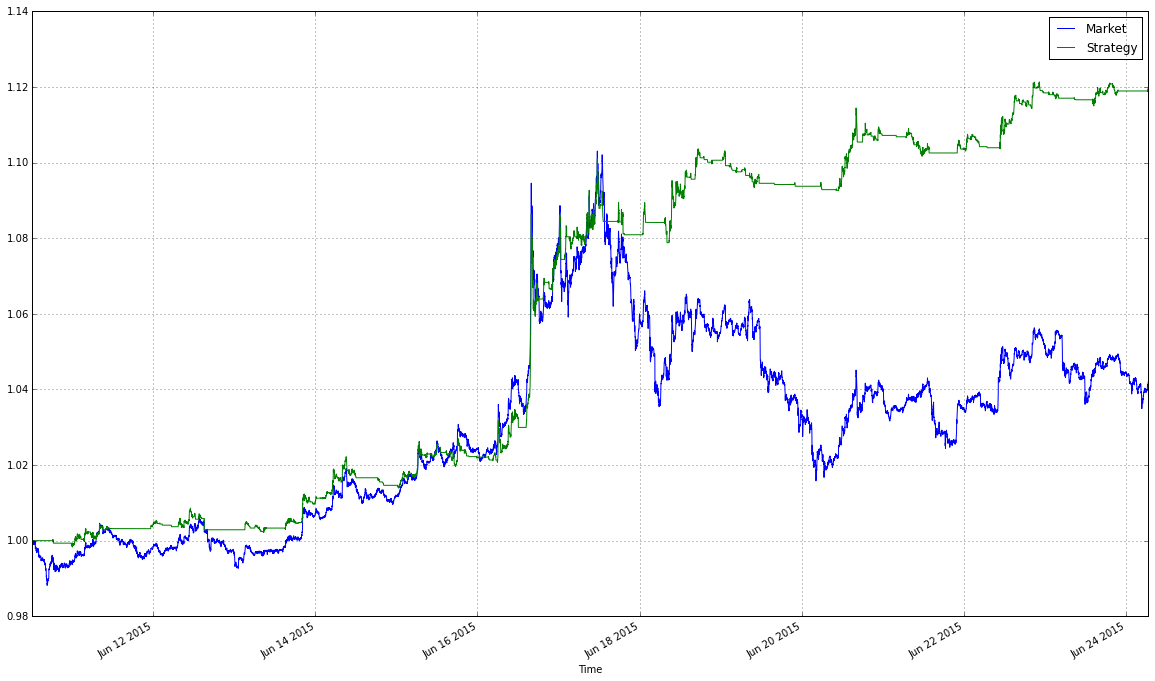

In [26]:


hourly_gains = pan.transpose(2,0,1)['hourly_gain'].transpose().dropna()

regimes = pan.transpose(2,0,1)['Regime'].transpose().dropna()

regimes['Market'] = df.dataset['Market']
regimes['winning_strategy_name'] = hourly_gains.idxmax(axis=1).dropna()

regimes = regimes[regimes['winning_strategy_name'].notnull()]
column_list = regimes.columns.values.tolist()
column_dict = {value:index for index, value in enumerate(column_list)}


winners = pd.DataFrame(regimes.ix[1440:])

winners['hourly_names'] = winners['winning_strategy_name'].asfreq(pd.DateOffset(minutes=1))
winners['hourly_names']=winners['hourly_names'].fillna(method='pad')
winners['Regime'] = 0
for group in column_list:
    winners["Regime"] = np.where(winners['hourly_names'] == group,winners[group],winners["Regime"])

s = Strategy(winners, name="Hourly Best")
s.dataset[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(20,12))


In [20]:
#strategies[80].dataset[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(20,12))

In [21]:
#pickle.dump(s,open('../resources/awesome_results', 'wb'))

In [22]:
# import matplotlib.pyplot as plt

# fig, ax1 = plt.subplots()
# ax1.plot(s.dataset[['Market', 'Strategy']].cumsum().apply(np.exp))#.plot(grid=True, figsize=(20,12))
# ax2 = ax1.twinx()
# ax2.plot(s.dataset[['Regime']])
# fig.set_size_inches(20,12)
# plt.show()
# #dir(fig)